In [1]:
import os
import netCDF4
import numpy as np
import pandas as pd
import requests
import io
import seaborn as sns

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches

In [2]:
#####################
##  DOWNLOAD DATA  ##
#####################

######################
#REANALYSIS DATA
######################
print('Model Data')
## Download selected month
import cdsapi
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means-preliminary-back-extension',
    {
        'product_type': 'reanalysis-monthly-means-of-daily-means',
        'variable': ['2m_temperature'],
        'year': [
            '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', 
            '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', 
            '1974', '1975', '1976', '1977', '1978'
        ],
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'time': '00:00',
        'area': [55, -180, 90, 180],
        'format': 'netcdf',
    },
    'ERA5_Art_t2m_1950-1978_prel.nc')

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['2m_temperature'],
        'year': [
            '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', 
            '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
            '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',            
            '2015', '2016', '2017', '2018', '2019', '2020',
        ],
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'time': '00:00',
        'area': [55, -180, 90, 180],
        'format': 'netcdf',
    },
    'ERA5_Art_t2m_1979-2020.nc')


#################
# Merge netcdfs
#################
filename_1 = 'ERA5_Art_t2m_1950-1978_prel.nc'
filename_2 = 'ERA5_Art_t2m_1979-2020.nc'

#Load netcdf
ncdf_1 = netCDF4.Dataset(filename_1)
ncdf_2 = netCDF4.Dataset(filename_2)

#Get dimensions
lons = ncdf_2.variables['longitude'][:]
lats = ncdf_2.variables['latitude'][:]
times_1 = ncdf_1.variables['time'][:]
times_2 = ncdf_2.variables['time'][:]
times = np.concatenate([times_1, times_2])

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m_1 = ncdf_1.variables['t2m'][:,:,:]
t2m_2 = ncdf_2.variables['t2m'][:,:,:]

t2m = np.concatenate([t2m_1, t2m_2])


#Write numpy array as NetCDF
ncout = netCDF4.Dataset('ERA5_Art_t2m_1950-2020.nc','w','NETCDF4_classic'); # using netCDF3 for output format 
ncout.createDimension('time',np.shape(t2m)[0])
ncout.createDimension('longitude',np.shape(t2m)[2])
ncout.createDimension('latitude',np.shape(t2m)[1])

timevar = ncout.createVariable('time','float64',('time')); timevar.setncattr('units','hours since 1900-01-01 00:00:00.0'); timevar[:]=times;

longitude = ncout.createVariable('longitude','float32',('longitude')); longitude[:] = ncdf_1.variables['longitude'][:];
latitude = ncout.createVariable('latitude','float32',('latitude')); latitude[:] = ncdf_1.variables['latitude'][:];

t2m_join = ncout.createVariable('t2m','float32',('time','latitude','longitude')); t2m_join.setncattr('units','K'); t2m_join[:] = t2m;

ncout.close();

Model Data


2021-06-17 19:18:24,030 INFO Welcome to the CDS
2021-06-17 19:18:24,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means-preliminary-back-extension
2021-06-17 19:18:24,085 INFO Request is queued
2021-06-17 19:18:25,142 INFO Request is running
2021-06-17 19:21:15,729 INFO Request is completed
2021-06-17 19:21:15,732 INFO Downloading https://download-0013.copernicus-climate.eu/cache-compute-0013/cache/data5/adaptor.mars.internal-1623950306.0760517-11003-14-a7ef5310-a1ea-4559-bf92-61a4a19a5626.nc to ERA5_Art_t2m_1950-1978_prel.nc (134.8M)
2021-06-17 19:22:01,106 INFO Download rate 3M/s                                                                        
2021-06-17 19:22:01,254 INFO Welcome to the CDS
2021-06-17 19:22:01,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2021-06-17 19:22:01,403 INFO Request is queued
2021-06-17 19:22:02,478 INFO R

In [3]:
#################
# Load data
#################

############################
## Load Mean Data
#Path
filename_m = 'ERA5_Art_1981-2010_mean.nc'

#Load netcdf
ncdf_m = netCDF4.Dataset(filename_m)

#Get dimension
lons = ncdf_m.variables['lons'][:]
lats = ncdf_m.variables['lats'][:]
months = ncdf_m.variables['month'][:]

#Get variables
#print(ncd_mf.variables)
t2m_m = ncdf_m.variables['t2m_mean'][:]

############################
## Load All Data
#Path
filename = 'ERA5_Art_t2m_1950-2020.nc'

#Load netcdf
ncdf = netCDF4.Dataset(filename)

#Get dimension
lons = ncdf.variables['longitude'][:]
lats = ncdf.variables['latitude'][:]
times = ncdf.variables['time'][:]

dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
#print(ncdf.variables)
t2m = ncdf.variables['t2m'][:]

Plot and save map
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970


<ipython-input-4-41401dc921bd>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=[3,3])


1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


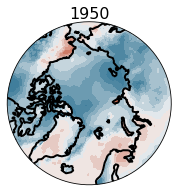

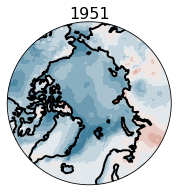

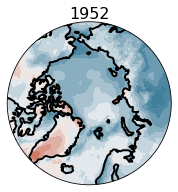

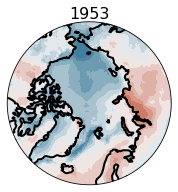

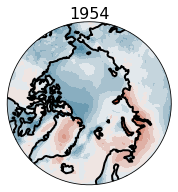

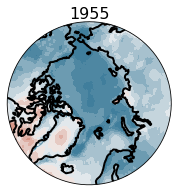

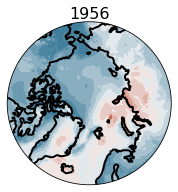

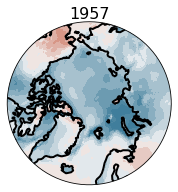

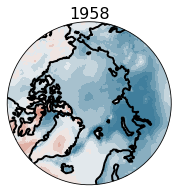

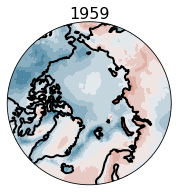

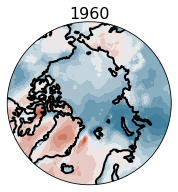

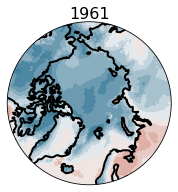

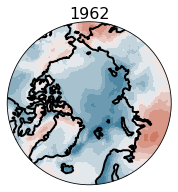

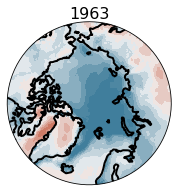

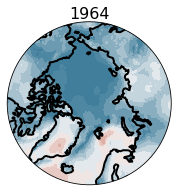

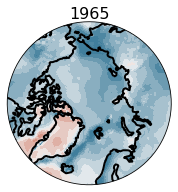

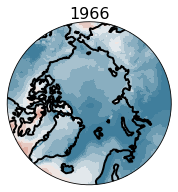

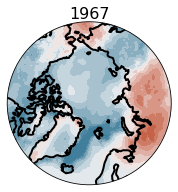

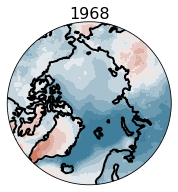

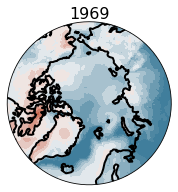

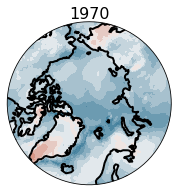

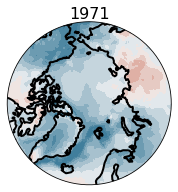

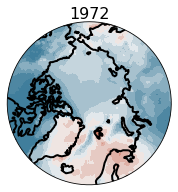

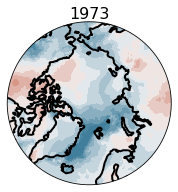

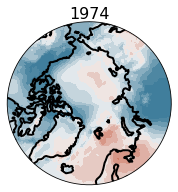

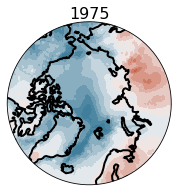

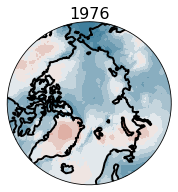

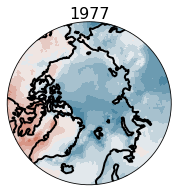

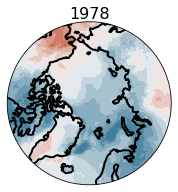

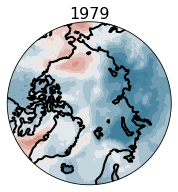

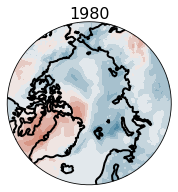

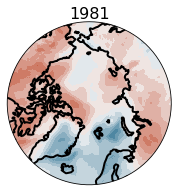

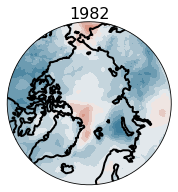

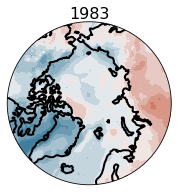

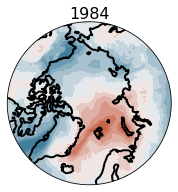

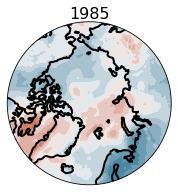

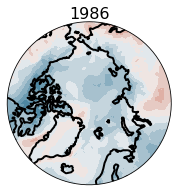

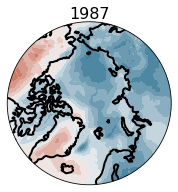

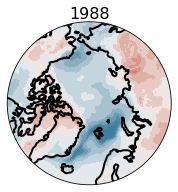

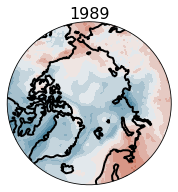

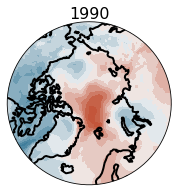

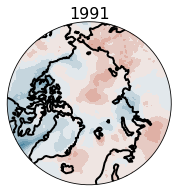

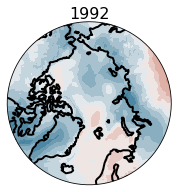

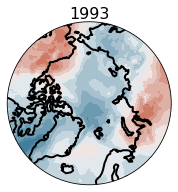

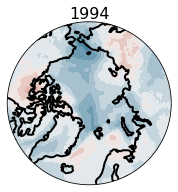

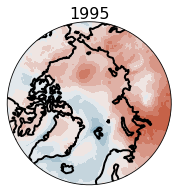

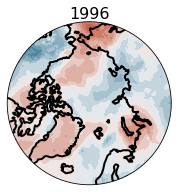

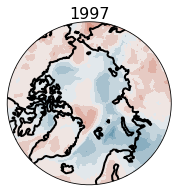

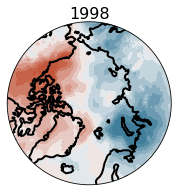

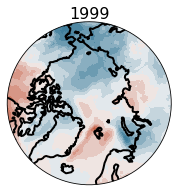

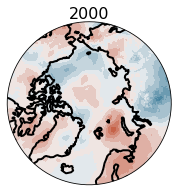

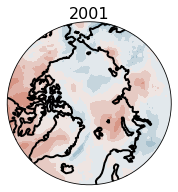

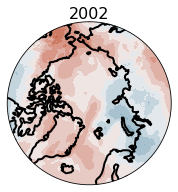

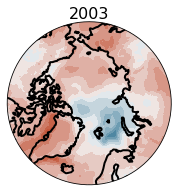

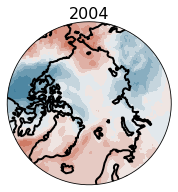

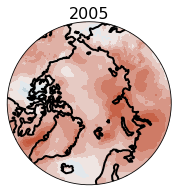

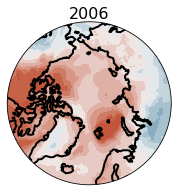

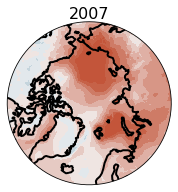

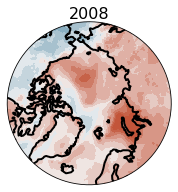

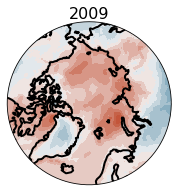

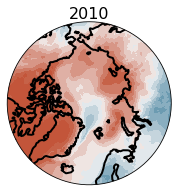

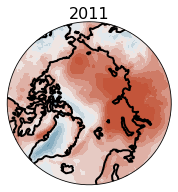

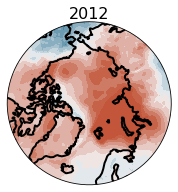

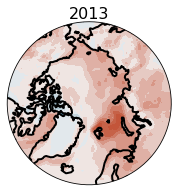

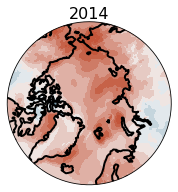

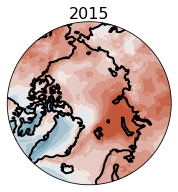

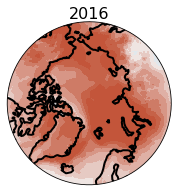

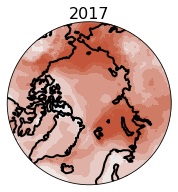

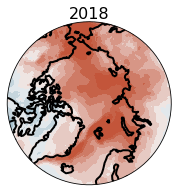

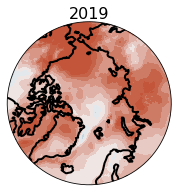

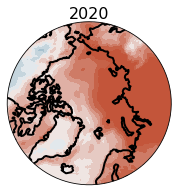

In [4]:
######################
#PLOT AND SAVE MAP
######################
print('Plot and save map')

for year in np.arange(1950,2021):
    print(year)
    ##Plot
    #Define map
    #Map parameters
    fig = plt.figure(figsize=[3,3])
    ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #Set circle boundary
    theta=np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5,0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts*radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.coastlines(resolution='110m', linewidth=2)

    #Plot ERA5
    ix = (year - 1950)*12
    t2m_anom = np.mean(t2m[ix:ix+12,:,:], axis=0)-np.mean(t2m_m[:,:,:], axis=0)
    CS1 = ax.contourf(lons, lats, t2m_anom[:,:], np.arange(-3,3.5,.5), cmap=cmap, transform=ccrs.PlateCarree(), extend='both')

    #Set Parameters
    #cb = plt.colorbar(CS2, orientation='horizontal', pad=0.05)
    #cb.set_label('T $^\circ$C', rotation=0, fontsize=12)
    plt.title(str(year), fontsize=16, pad=0)
    #ax.annotate(' Reference Period: 1981-2010 | Data: ERA5 & Met-READER',
    #            xy=(1, 0.06), xytext=(0, 10),
    #            xycoords=('axes fraction', 'figure fraction'),
    #            textcoords='offset points',
    #            size=10, ha='right', va='bottom')

    #Saveplot
    plt.savefig('Tanomaly_AllArt_'+str(year)+'.png', dpi=1000)
    #plt.close()

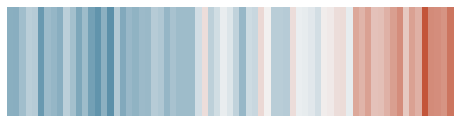

In [5]:
######################
#PLOT STRIPES
######################

years = np.arange(1950,2021)
T_Art = np.zeros(np.size(years))
for i,year in enumerate(np.arange(1950,2021)):
    ix = (year - 1950)*12
    T_Art[i] = np.mean(t2m[ix:ix+12,:-20,:])-np.mean(t2m_m[:,:-20,:])
    
fig = plt.figure(figsize=[8,2])
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data=[T_Art,T_Art],
           cmap=cmap, cbar=False,
           vmin=-2.5, vmax=2.5, center=0.,
           xticklabels=False, yticklabels=False,
           )
ax.plot(years, T_Art, '-k', zorder=5)
plt.savefig('StripePlot_Art.png')